<a href="https://colab.research.google.com/github/ravindra46/_XAI_P/blob/main/XAI_Practitioners_for_single_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Integrated Gradients***

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
print(tf.__version__)

2.12.0


In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [4]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [6]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


In [7]:
imagenet_labels[0]

'background'

In [8]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

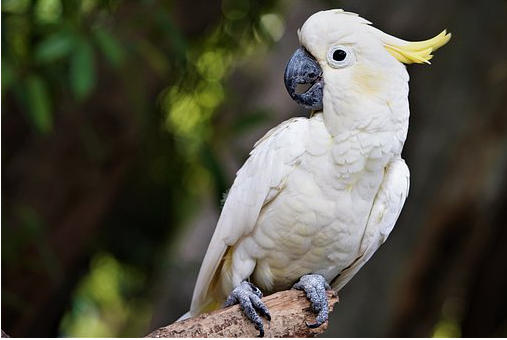

In [10]:
img_path = '/content/Screenshot (334).png'
tf.keras.utils.load_img(img_path, grayscale=False)

In [11]:
image_tensor = read_image(img_path)

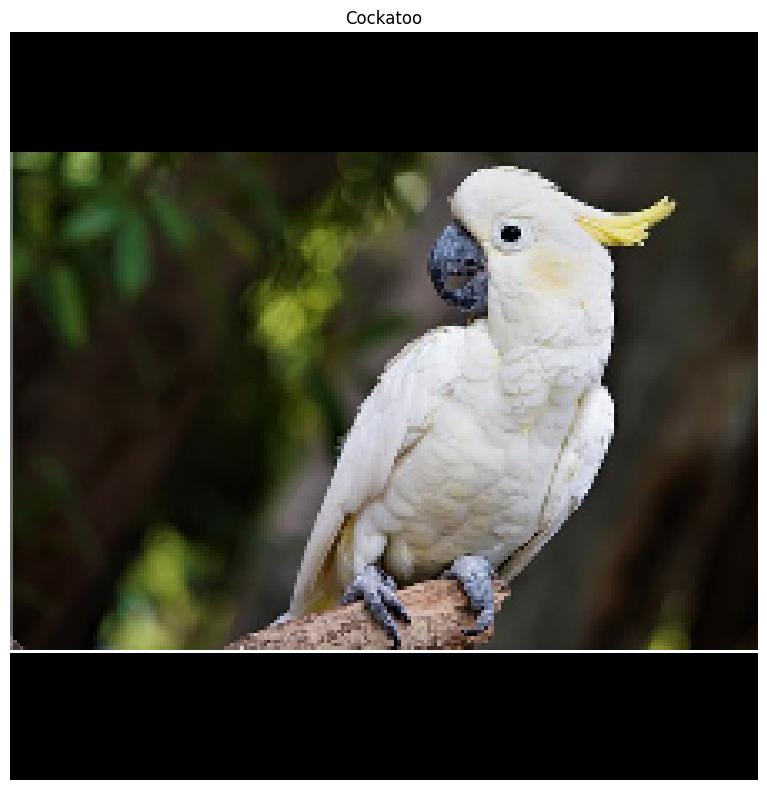

In [12]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.imshow(image_tensor)
ax.set_title('Cockatoo')
ax.axis('off')
plt.tight_layout()

In [19]:
def top_k_predictions(img, k=4):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [20]:
pred_label, pred_prob = top_k_predictions(image_tensor)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.5%}')

sulphur-crested cockatoo: 99.02467%
spoonbill: 0.18730%
macaw: 0.05328%
ptarmigan: 0.04918%



***Baselines***

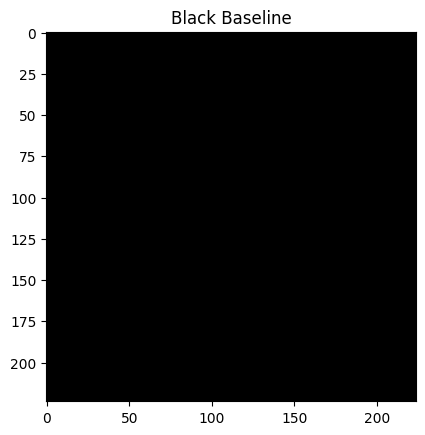

In [21]:
black_baseline = tf.zeros(shape=(224,224,3))
plt.imshow(black_baseline)
plt.title("Black Baseline")
plt.axis('on')
plt.show()

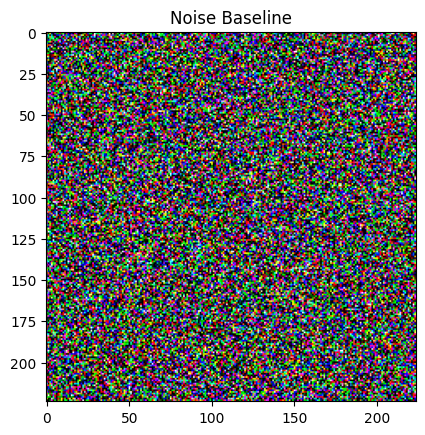

In [22]:
noise_baseline = tf.random.normal(shape=(224,224,3))
plt.imshow(noise_baseline)
plt.title("Noise Baseline")
plt.axis('on')
plt.show()

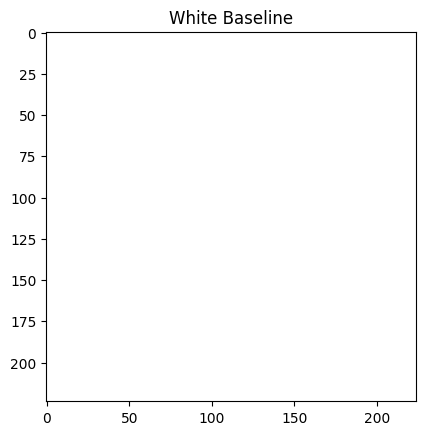

In [23]:
white_baseline = tf.ones(shape=(224,224,3))
plt.imshow(white_baseline)
plt.title("White Baseline")
plt.axis('on')
plt.show()

In [24]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    images = alphas_x * input_x + (1 - alphas_x) * baseline_x
    return images

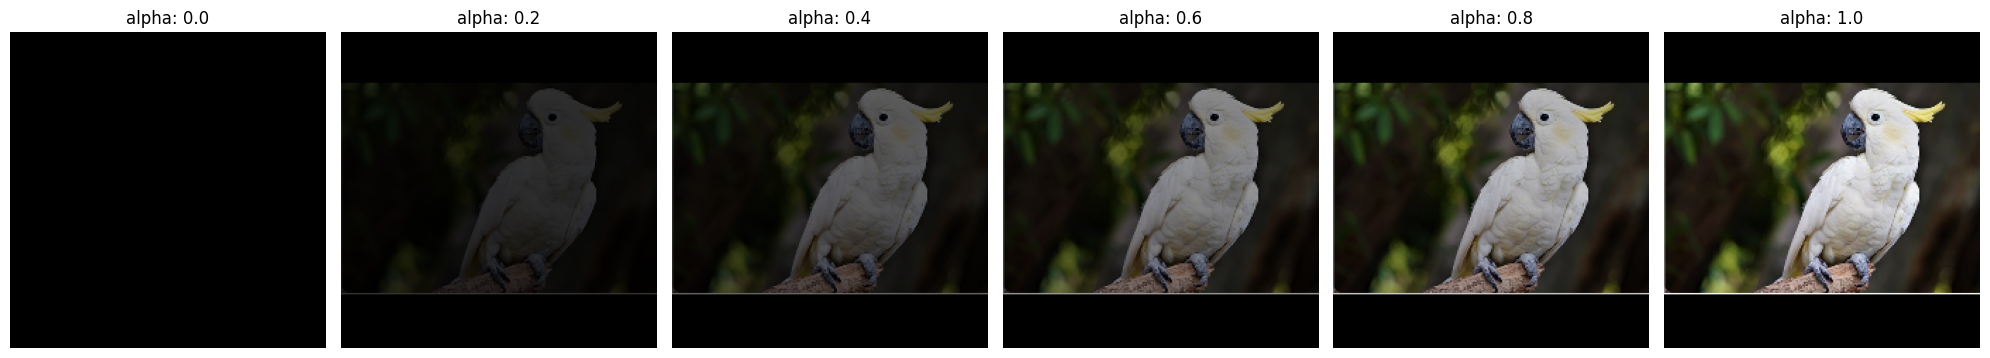

In [25]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(black_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


In [26]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [27]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

idx_cockatoo = np.where(imagenet_labels==LABEL)[0][0]
pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

In [28]:
pred_proba

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.0011114 , 0.00157281, 0.13961565, 0.557414  , 0.78749615,
       0.8907953 , 0.9441138 , 0.96491045, 0.97967803, 0.9877152 ,
       0.9921939 , 0.99491197, 0.996133  , 0.9968326 , 0.99699587,
       0.9971448 , 0.99716145, 0.9971047 , 0.9971517 , 0.9970474 ,
       0.9970068 , 0.9970241 , 0.99702936, 0.99697495, 0.99687964,
       0.9968168 , 0.99669796, 0.99657947, 0.99638563, 0.99612254,
       0.9958107 , 0.9954043 , 0.9949786 , 0.9945393 , 0.99410594,
       0.99376875, 0.9934454 , 0.9931975 , 0.9928935 , 0.9926344 ,
       0.99244255, 0.9921397 , 0.99182343, 0.9915354 , 0.991326  ,
       0.99114615, 0.99100333, 0.9908787 , 0.9906883 , 0.9904495 ,
       0.99024665], dtype=float32)>

(0.0, 1.05)

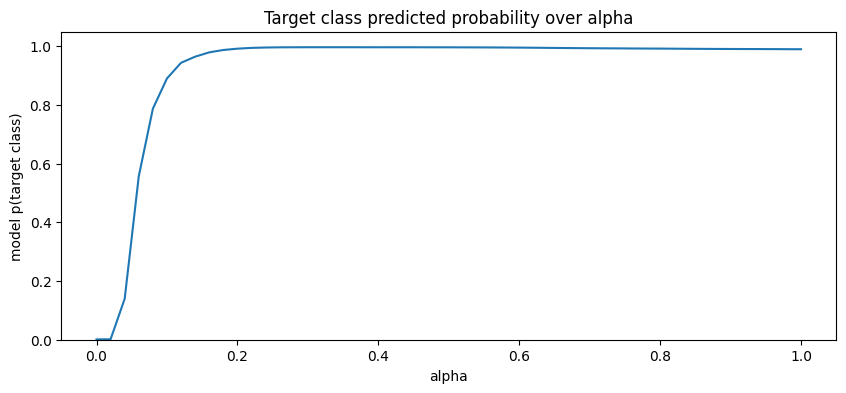

In [29]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

In [30]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=idx_cockatoo)

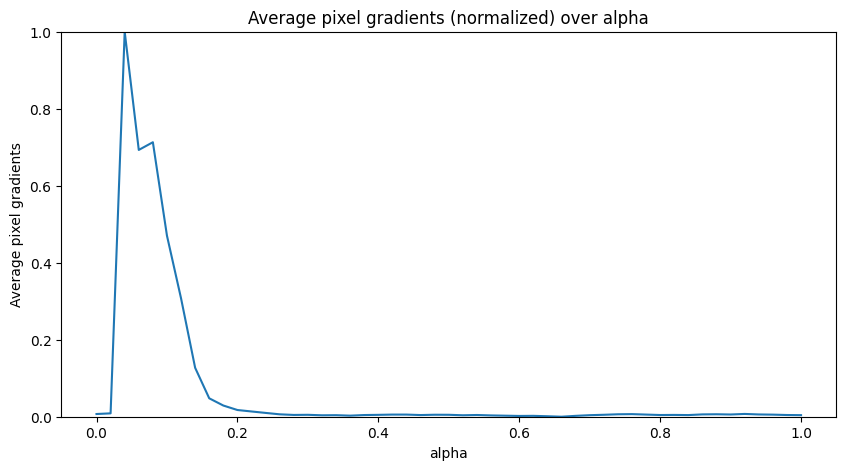

In [32]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 1, 1)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax1.plot(alphas, average_grads_norm)
ax1.set_title('Average pixel gradients (normalized) over alpha')
ax1.set_ylabel('Average pixel gradients')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1]);

*** White Baseline or Noise Baseline***

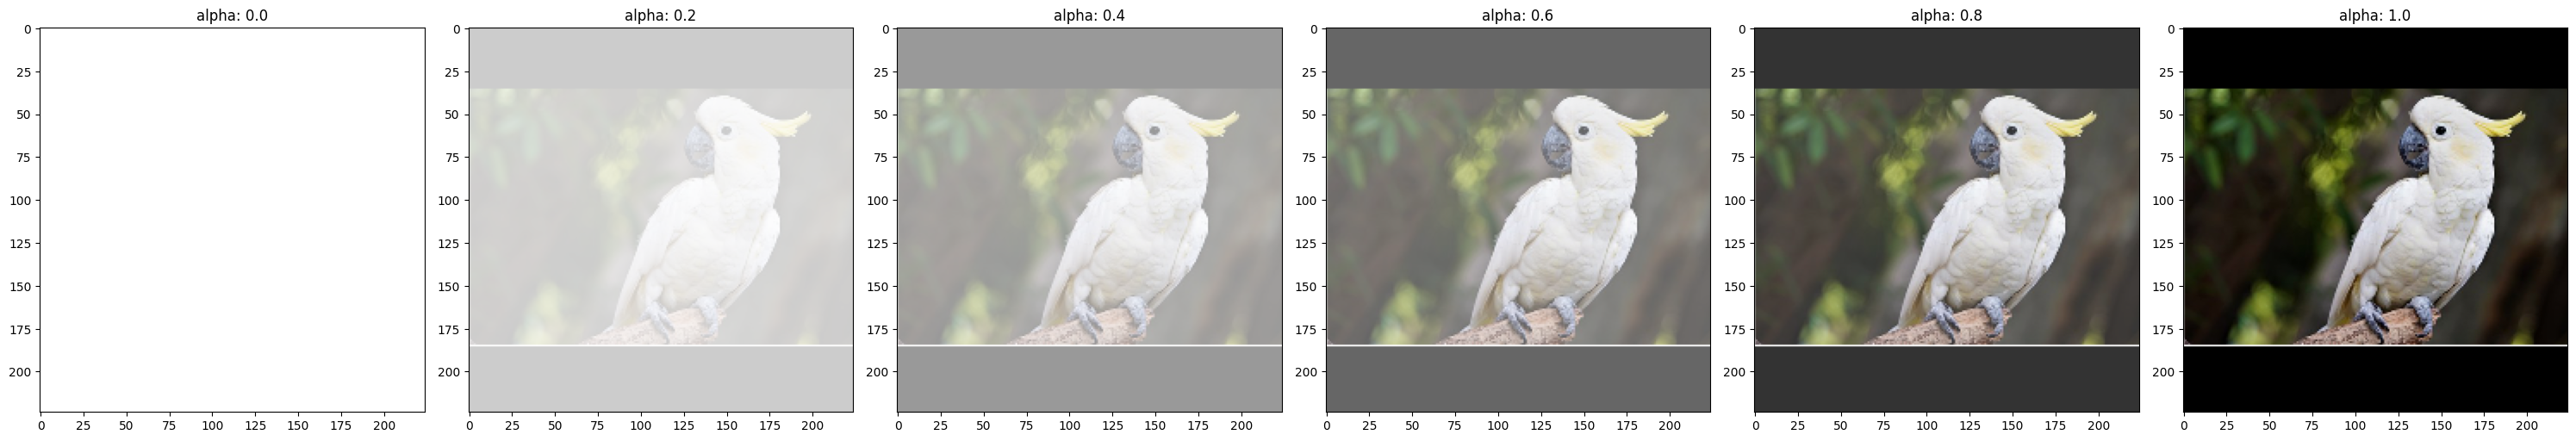

In [34]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(white_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(30, 30))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('on')

plt.tight_layout();

(0.0, 1.05)

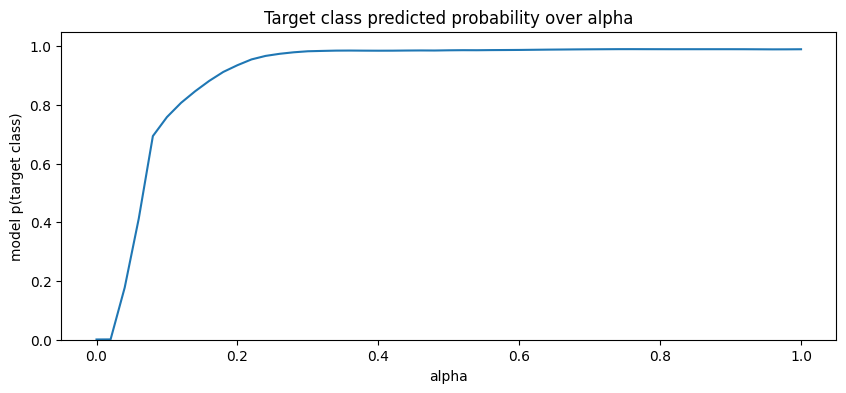

In [35]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

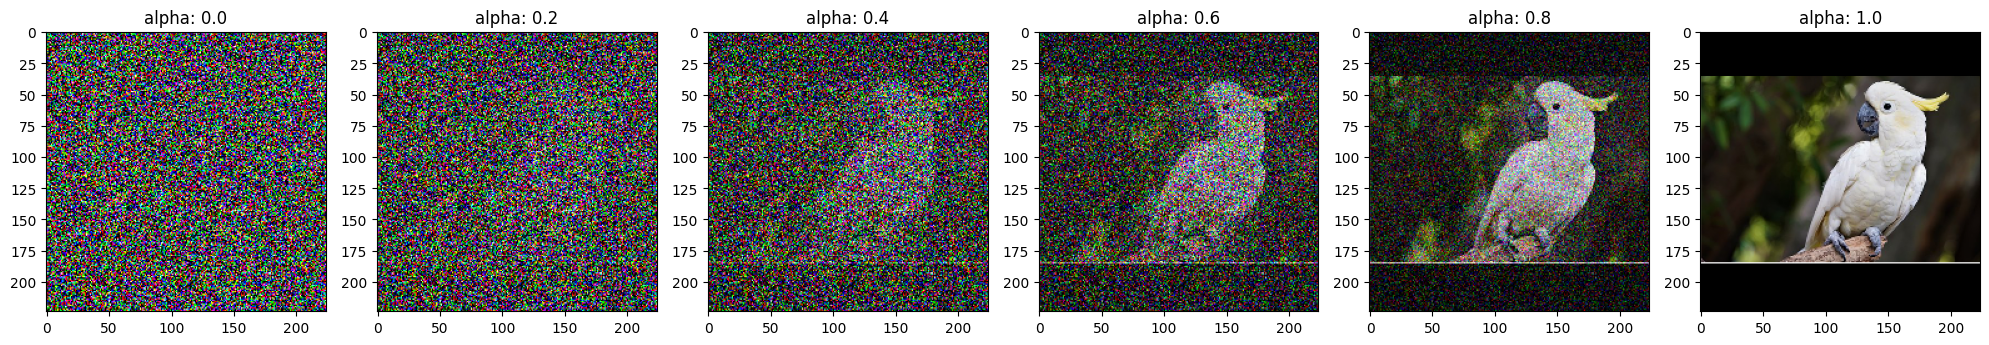

In [36]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(noise_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('on')

plt.tight_layout();

(0.0, 1.05)

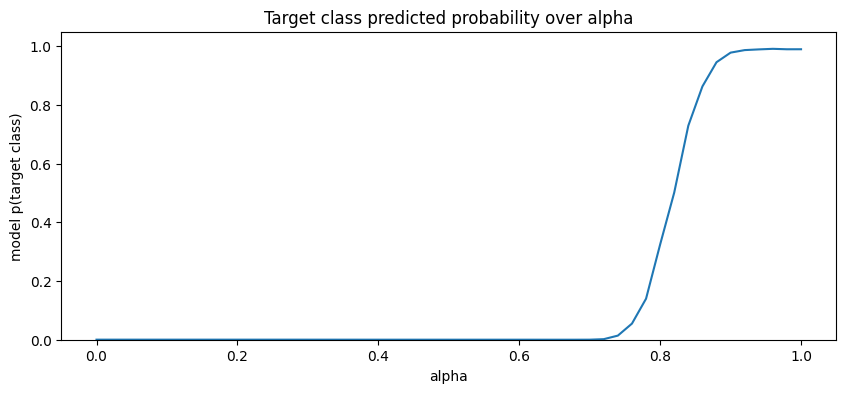

In [37]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

In [38]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [39]:
ig = integral_approximation(
    gradients=path_gradients)

In [40]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [41]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [42]:
ig_attributions = integrated_gradients(baseline=black_baseline,
                                       image=image_tensor,
                                       target_class_idx=90,
                                       m_steps=240)

In [43]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

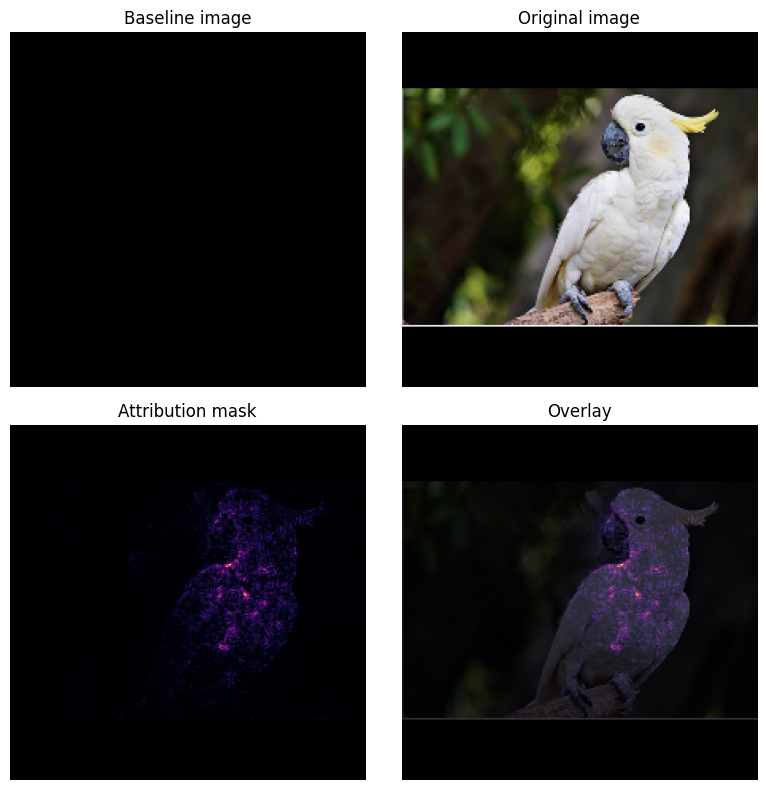

In [45]:
_ = plot_img_attributions(image=image_tensor,
                          baseline=black_baseline,
                          target_class_idx=90,
                          m_steps=10,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.2)
#Using Inceptin v3 and with m_steps = 10


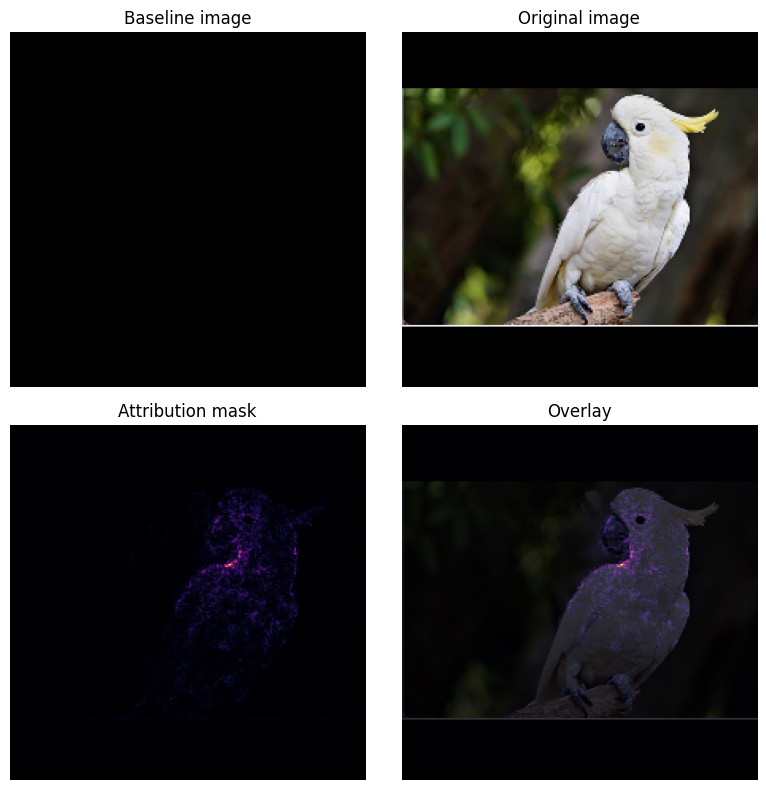

In [46]:
#Using Inceptin v3 and with m_steps = 50
_ = plot_img_attributions(image=image_tensor,
                           baseline=black_baseline,
                           target_class_idx=90,
                           m_steps=50,
                           cmap=plt.cm.inferno,
                           overlay_alpha=0.2)

***Computing Integrated Gradients using the Saliency library***
